In [166]:
from scipy.sparse import load_npz

train_csr = load_npz('../train_user_csr.npz')
test_X_csr = load_npz('../testx_user_csr.npz')
test_y_csr = load_npz('../testy_user_csr.npz')

In [167]:
from scipy.sparse import csr_matrix

class RecommendationAlgorithm:
  def __init__(self):
    pass

  def fit(self, training_ratings: csr_matrix) -> None:
    # Train the model on the training ratings
    pass

  def predict(self, user_ratings: csr_matrix) -> csr_matrix:
    # Predict the ratings for the given users and items
    pass

In [168]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfTransformer

class KNNAlgorithm(RecommendationAlgorithm):
  def __init__(self, n_neighbors=5, distance_metric='cosine', weight_by_idf=False, normalizer=None):
    self.nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric=distance_metric)
    self.normalizer = normalizer
    if weight_by_idf:
      self.transformer = TfidfTransformer(norm=normalizer)
    self.train = []
    self.weight_by_idf = weight_by_idf

  def fit(self, train: csr_matrix):
    # Train the model on the training ratings
    if self.weight_by_idf:
      _train = self.transformer.fit_transform(train)
    self.train = train
    self.nn_model.fit(_train)

  def predict(self, seen: csr_matrix, n=100):
    # Predict the ratings for the given users and items
    if self.weight_by_idf:
      _seen = self.transformer.transform(seen)
    neighbors = self.nn_model.kneighbors(_seen, return_distance=False)
    predicted_ratings = []
    for (user_idx, user_neighbors_idx) in enumerate(neighbors):
      averages = np.ravel(self.train[user_neighbors_idx, :].mean(axis=0))
      already_added = np.sort(seen.indices[seen.indptr[user_idx]:seen.indptr[user_idx+1]])
      averages[already_added] = -1
      topn = np.argpartition(-averages, n)[:n]
      predicted_ratings.append(topn[np.argsort(-averages[topn])])
    return predicted_ratings


In [169]:
np.seterr(divide='ignore', invalid='ignore')

model = KNNAlgorithm(n_neighbors = 5, distance_metric = 'cosine', weight_by_idf=True, normalizer='l2')
model.fit(train_csr)

In [170]:
def batch_generator(a:csr_matrix, b:csr_matrix, batch_size:int = 1000):
    num_samples = a.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)

        yield a[start_idx:end_idx], b[start_idx:end_idx]

In [171]:
batch_size = 1000
batch_gen = batch_generator(test_X_csr, test_y_csr, batch_size)

pred = []
actual = []

batch_gen = batch_generator(test_X_csr, test_y_csr, 1000)

for seen, unseen in batch_gen:
  nnz = unseen.nonzero()
  actual.extend([nnz[1][nnz[0] == i].tolist() for i in range(unseen.shape[0])])

  batch_pred = model.predict(seen)
  pred.extend(batch_pred)

In [161]:
def true_positives(pred, actual):
    # predicted candidate, true user interaction
    return len(np.intersect1d(pred, actual))

def false_positives(pred, actual):
    # predicted candidate, not user interaction
    return len(pred[~np.isin(pred, actual)])

def false_negatives(pred, actual):
    # not predicted candidate, true user interaction
    return len(actual) - true_positives(pred, actual)

In [172]:
def avg_precision(pred, actual):
    _tp = 0
    precision = 0.0

    if true_positives(pred, actual) == 0:
        return 0.0
    
    for i, cur in enumerate(pred):
        if cur in actual:
            _tp += 1
            precision += _tp /  (i + 1)
    
    return precision / _tp

def mean_avg_precision(pred, actual):
    precisions = []
    for cur_pred, cur_actual in zip(pred, actual):
        precisions.append(avg_precision(cur_pred, cur_actual))
    
    return np.mean(precisions)

print("MAP: {:.4f}".format(mean_avg_precision(pred, actual)))

MAP: 0.2290


In [173]:
import numpy as np

def recall_at_k(pred, actual, k):
    recall_sum = 0.0
    num_users = len(actual)
    
    for i in range(num_users):
        true_set = set(actual[i])
        pred_set = set(pred[i][:k])
        recall_sum += len(true_set.intersection(pred_set)) / float(len(true_set))
    
    recall_at_k = recall_sum / num_users
    return recall_at_k

for k in [5,10,15,20,30,40,50,60,70,80,90,100]:
    recall = recall_at_k(pred, actual, k)
    print("Recall@{}: {:.4f}".format(k, recall))


Recall@5: 0.0701
Recall@10: 0.1078
Recall@15: 0.1339
Recall@20: 0.1537
Recall@30: 0.1824
Recall@40: 0.2033
Recall@50: 0.2202
Recall@60: 0.2345
Recall@70: 0.2471
Recall@80: 0.2586
Recall@90: 0.2686
Recall@100: 0.2777


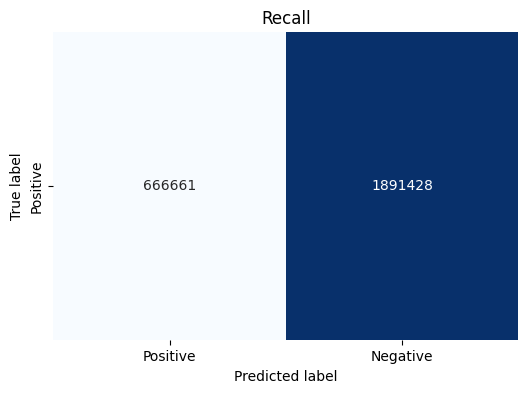

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

tp = sum([true_positives(x,y) for x, y in zip(pred, actual)])
fp = sum([false_positives(x,y) for x, y in zip(pred, actual)])
fn = sum([false_negatives(x,y) for x, y in zip(pred, actual)])


# Plot confusion matrix without true negatives
plt.figure(figsize=(6, 4))
sns.heatmap([[tp, fn]], annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive'])
plt.title('Recall')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [178]:
np.save('cf_knn_candidates', pred)